# Brainhack 2019 - starter kit

By [Piotr Migdał](https://p.migdal.pl) and Katarzyna Kańska.


## Notebook 1: Simple networks for image classification
We will use a subset of [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset).

Conveniet way to download selected classes (using [gsutil](https://cloud.google.com/storage/docs/gsutil_install)) `gsutil -m cp "gs://quickdraw_dataset/full/numpy_bitmap/*.npy" .`

See: https://www.tensorflow.org/tutorials/sequences/recurrent_quickdraw

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import nn, optim
from torch.utils import data
import torchvision
from torchvision import datasets, transforms

from livelossplot import PlotLosses

In [2]:
torch.manual_seed(42)

## Data loading

In [3]:
classes = ["apple", "spider", "octopus", "snowflake"]
limit = 500
images = []

for label in classes:
    X = np.load('../google_draw/{}.npy'.format(label))
    print("Loaded {} out of {} {}s".format(limit, X.shape[0], label))
    images.append(X[:limit])

X = np.concatenate(images)
Y = np.concatenate([limit * [i] for i in range(len(classes))])

Loaded 500 out of 144722 apples
Loaded 500 out of 209447 spiders
Loaded 500 out of 150152 octopuss
Loaded 500 out of 116685 snowflakes


In [4]:
X = X.reshape(-1, 1, 28, 28)
X = X.astype('float32') / 255.
X = np.pad(X, [(0, 0), (0, 0), (2, 2), (2, 2)], mode='constant')

# (samples, channels, x, y)
X.shape

(2000, 1, 32, 32)

## Train-test split

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

## Datasets and data loaders

We need to create data loaders to load and preprocess data. We use split:
* train - for training,
* validation - not used for training, but to evaluate model performance.

In [6]:
# define data loaders
dataloaders = {
    'train':
    data.DataLoader(
        data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train).long()),
        batch_size=64,
        shuffle=True, num_workers=4
    ),
    'validation': 
    data.DataLoader(
        data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test).long()),
        batch_size=64,
        shuffle=False, num_workers=4
    )
}

## Before we start

While training a model, it is important to set `train` or `eval` mode of the model, as some layers have different behavior during train and evaluation.

See also: [Keras vs. PyTorch: Alien vs. Predator recognition with transfer learning](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning) which explains API differences between these frameworks.

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10, metrics={}):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels.data).sum().item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
            
            metrics[phase] = {
                'log loss': epoch_loss,
                'accuracy': epoch_acc
            }
        
        liveloss.update(logs)
        liveloss.draw()
    return model

In [8]:
device

device(type='cuda', index=0)

## Convolutional neural network

In [9]:
# antipattern in PyTorch, don't do it!
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self._conv_block(1, 16)
        self.conv2 = self._conv_block(16, 32)
        self.conv3 = self._conv_block(32, 64)
        
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, len(classes))
        )
    
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [11]:
def make_connector(in_channels, out_channels, intermediate_channels=None):
    if not intermediate_channels:
        intermediate_channels = in_channels
    
    return nn.Sequential(
        nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, padding=0),
        nn.ReLU(inplace=True),
        nn.Conv2d(intermediate_channels, out_channels, kernel_size=1, padding=0),
        nn.ReLU(inplace=True)
    )

In [12]:
class SewnConvNet(nn.Module):
    def __init__(self, net_before, net_after, connector):
        super().__init__()
        self.net_before = net_before.eval()
        self.net_after = net_after.eval()
        self.connector = connector
        
        self._assert_channels()
    
    def forward(self, x):
        x = self.net_before(x)
        x = self.connector(x)
        x = self.net_after(x)
        return x
    
    def _assert_channels(self):
        '''
        net_before, net_after, connector - nn.Sequential or nn.ModuleList
        '''
        before_out_channels = self._find_out_channels(self.net_before)
        connector_in_channels = self._find_in_channels(self.connector)
        if before_out_channels != connector_in_channels:
            raise ValueError('Connector has {} input channels, expected {}.'.format(
                connector_in_channels, before_out_channels)
            )
        
        connector_out_channels = self._find_out_channels(self.connector)
        after_in_channels = self._find_in_channels(self.net_after)
        if after_in_channels != connector_out_channels:
            raise ValueError('Connector has {} output channels, expected {}.'.format(
                connector_out_channels, after_in_channels)
            )
    
    def parameters(self, recurse=True):
        return self.connector.parameters()
    
    def train(self, mode=True):
        self.training = mode
        self.connector.train(mode)
        return self
    
    def eval(self):
        return self.train(False)
    
    def _find_in_channels(self, half):
        for m in half.modules():
            if isinstance(m, nn.Conv2d):
                return m.in_channels
            if isinstance(m, nn.Linear):
                return m.in_features // 16  # be carefull!
    
    def _find_out_channels(self, half):
        out_channels = None
        for m in half.modules():
            if isinstance(m, nn.Conv2d):
                out_channels = m.out_channels
            if isinstance(m, nn.Linear):
                out_channels = m.out_features
        return out_channels

In [13]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

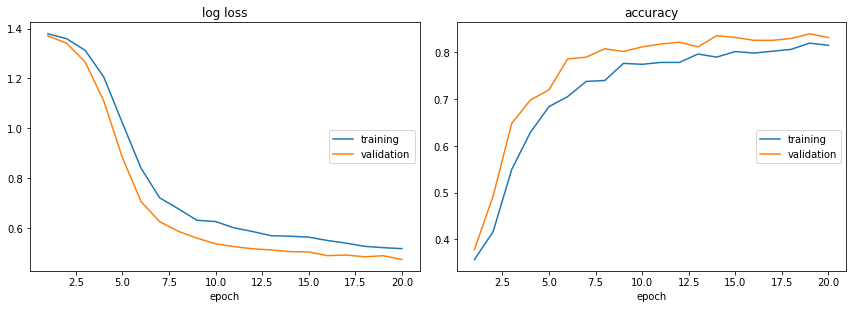

log loss:
training   (min:    0.516, max:    1.379, cur:    0.516)
validation (min:    0.473, max:    1.371, cur:    0.473)

accuracy:
training   (min:    0.357, max:    0.820, cur:    0.815)
validation (min:    0.378, max:    0.840, cur:    0.832)


In [14]:
basic_model_metrics = {}
model_trained = train_model(model, criterion, optimizer, num_epochs=20, metrics=basic_model_metrics)

## Implant layer into one trained network

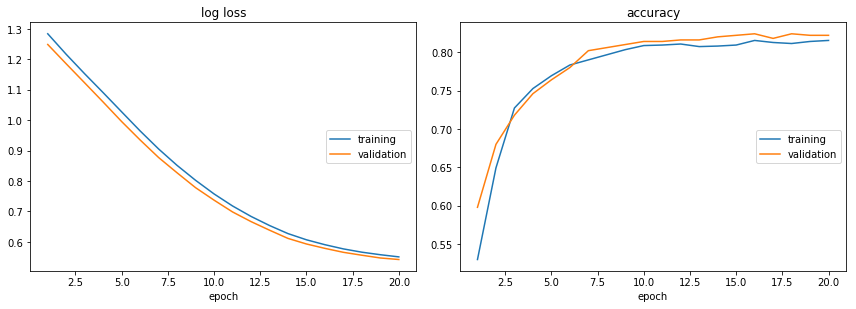

log loss:
training   (min:    0.551, max:    1.284, cur:    0.551)
validation (min:    0.542, max:    1.249, cur:    0.542)

accuracy:
training   (min:    0.530, max:    0.815, cur:    0.815)
validation (min:    0.598, max:    0.824, cur:    0.822)


In [15]:
layers = list(model_trained.children())
out_channels = 16

metrics_all = []

for i in range(1, len(layers)):
    net_before = nn.Sequential(*layers[:i])
    net_after = nn.Sequential(*layers[i:])
    connector = make_connector(out_channels, out_channels)
    out_channels *= 2
    
    sewn_model = SewnConvNet(net_before, net_after, connector)
    optimizer = optim.Adam(sewn_model.parameters(), lr=1e-4)
    
    metrics = {}
    sewn_model_trained = train_model(sewn_model, criterion, optimizer, num_epochs=20, metrics=metrics)
    
    for phase, values in metrics.items():
        metrics_all.append({
            'phase': phase,
            'after which layer': 'conv{}'.format(i),
            **values
        })

In [16]:
def draw_chart(df, metric_name, threshold, threshold_name):
    sns.catplot('after which layer', 'accuracy', 'phase', data=df, kind='bar', palette='muted')
    plt.annotate(threshold_name, xy=(2.5, threshold))
    plt.axhline(threshold, color='r')
    plt.show()

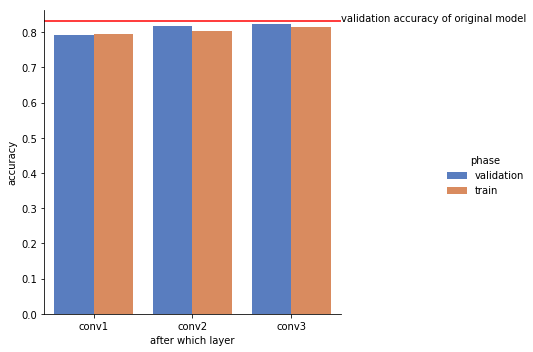

In [21]:
df = pd.DataFrame(metrics_all)
draw_chart(df, 'accuracy', basic_model_metrics['validation']['accuracy'], 'validation accuracy of original model')

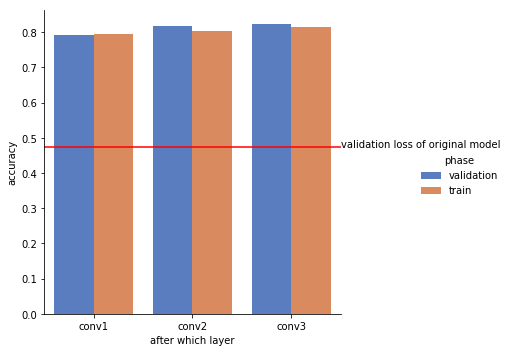

In [22]:
draw_chart(df, 'log loss', basic_model_metrics['validation']['log loss'], 'validation loss of original model')

In [19]:
%load architectures/small-resnet.py

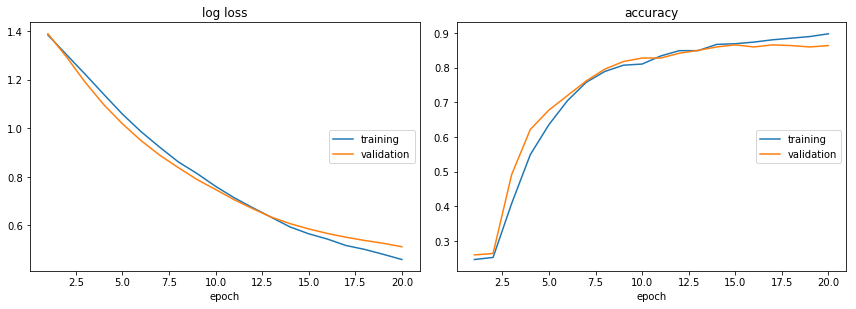

log loss:
training   (min:    0.460, max:    1.384, cur:    0.460)
validation (min:    0.512, max:    1.389, cur:    0.512)

accuracy:
training   (min:    0.247, max:    0.898, cur:    0.898)
validation (min:    0.260, max:    0.866, cur:    0.864)


In [20]:
model_residual = MicroResNet(num_classes=4, in_channels=1)
optimizer_residual = optim.Adam(model_residual.parameters(), lr=1e-5)

metrics = {}
model_residual_trained = train_model(model_residual, criterion, optimizer_residual, num_epochs=20, metrics=metrics)